In [1]:
import numpy as np

import os
import time
import warnings

import pandas as pd
import numpy as np

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

from keras.layers import RepeatVector
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
sales_data = pd.read_csv("time-series/data/tractor-sales.csv")
sales_data.drop(['Month-Year'], axis=1, inplace=True)
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
sales_data.head(5)

,Tractor-Sales
0,141
1,157
2,185
3,199
4,203


In [3]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))

In [4]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
sales_data.set_index(dates, inplace=True)

In [5]:
# extract out the time-series
sales_ts = sales_data['Tractor-Sales']

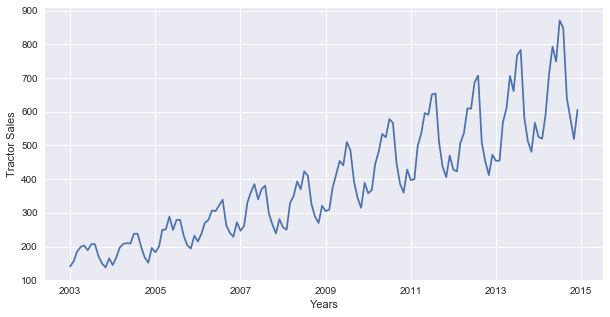

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales');

In [7]:
# LSTM for international airline passengers problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)

In [8]:
# load the dataset
# dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = sales_ts.values
dataset = dataset.astype('float32')

In [9]:
dataset

array([ 141.,  157.,  185.,  199.,  203.,  189.,  207.,  207.,  171.,
        150.,  138.,  165.,  145.,  168.,  197.,  208.,  210.,  209.,
        238.,  238.,  199.,  168.,  152.,  196.,  183.,  200.,  249.,
        251.,  289.,  249.,  279.,  279.,  232.,  204.,  194.,  232.,
        215.,  239.,  270.,  279.,  307.,  305.,  322.,  339.,  263.,
        241.,  229.,  272.,  247.,  261.,  330.,  362.,  385.,  340.,
        370.,  381.,  299.,  266.,  239.,  281.,  257.,  250.,  329.,
        350.,  393.,  370.,  423.,  410.,  326.,  289.,  270.,  321.,
        305.,  310.,  374.,  414.,  454.,  441.,  510.,  486.,  393.,
        345.,  315.,  389.,  358.,  368.,  444.,  482.,  534.,  524.,
        578.,  567.,  447.,  386.,  360.,  428.,  397.,  400.,  498.,
        536.,  596.,  591.,  651.,  654.,  509.,  437.,  406.,  470.,
        428.,  423.,  507.,  536.,  610.,  609.,  687.,  707.,  509.,
        452.,  412.,  472.,  454.,  455.,  568.,  610.,  706.,  661.,
        767.,  783.,

In [10]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

In [11]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

In [12]:
train_size

96

In [13]:
test_size

48

In [14]:
test_size + train_size

144

In [15]:
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [16]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [17]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [18]:
# create and fit the LSTM network
def model1():
    model = Sequential()
    model.add(LSTM(units=4, input_shape=(look_back, 1)))
    model.add(Dense(1))
    return model

In [19]:
def model2():
    model = Sequential()

    model.add(LSTM(units=50, input_shape=(look_back, 1), return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    model.add(Activation("linear"))
    return model

In [20]:
model = model1()

In [21]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [22]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [23]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [24]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 38.21 RMSE


In [25]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 86.07 RMSE


In [26]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back : look_back + len(trainPredict), :] = trainPredict

In [27]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[look_back + len(trainPredict) + look_back + 1: len(dataset) - 1, :] = testPredict

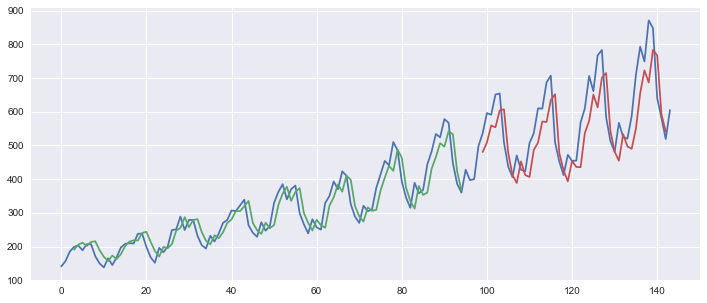

In [28]:
# plot baseline and predictions
plt.figure(figsize=(12, 5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Forecasting

In [101]:
dataset = sales_ts.values
dataset = dataset.astype('float32')

In [102]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

In [103]:
data = np.expand_dims(dataset[-look_back:], axis=0)
data

array([[[ 0.60436559],
        [ 0.51978171],
        [ 0.63710779]]], dtype=float32)

In [104]:
data[0]

array([[ 0.60436559],
       [ 0.51978171],
       [ 0.63710779]], dtype=float32)

In [105]:
forecast_window = 3

In [106]:
curr_frame = data[0]
predicted = []
for i in range(forecast_window):
    predicted.append(model.predict(np.expand_dims(curr_frame, axis=0))[0, 0])
    curr_frame = curr_frame[1:]
    curr_frame = np.insert(curr_frame, [look_back - 1], predicted[-1], axis=0)

In [107]:
predicted

[0.58178645, 0.53615934, 0.49222127]

In [108]:
len(dataset)

144

In [109]:
len(predicted)

3

In [110]:
actual = np.empty(shape=(len(dataset) + forecast_window, 1))
actual[:, :] = np.nan

In [111]:
forecasts = np.empty_like(actual)
forecasts[:, :] = np.nan

In [112]:
dataset.shape

(144, 1)

In [113]:
actual.shape

(147, 1)

In [114]:
actual[0:len(dataset),:] = dataset
forecasts[len(dataset):] = np.reshape(predicted, (forecast_window, 1))

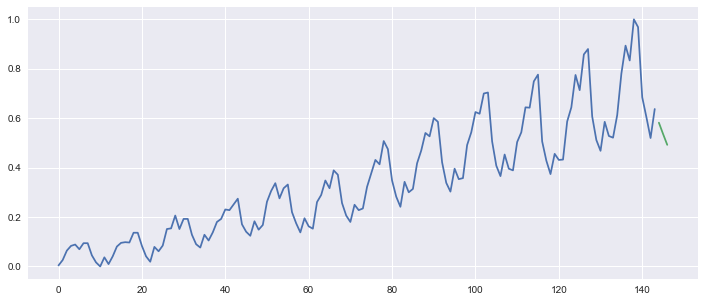

In [115]:
plt.figure(figsize=(12, 5))
plt.plot(actual)
plt.plot(forecasts);

### Forecast

In [93]:
#dataset = sales_ts.values
#dataset = dataset.astype('float32')

In [94]:
# normalize the dataset
#scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(dataset.reshape(-1, 1))

In [95]:
#dataX = []
#for i in range(len(dataset)-look_back + 1):
#    a = dataset[i:(i+look_back), 0]
#    dataX.append(a)
#dataX = np.array(dataX)

In [96]:
# reshape input to be [samples, time steps, features]
#dataX = np.reshape(dataX, (dataX.shape[0], dataX.shape[1], 1))

In [97]:
#alld = []
#alld.append(dataset)

In [98]:
#forecast_window = 12

In [100]:
#for i in range(forecast_window):
#    dataXpred = model.predict(dataX)
#    alld.append(dataXpred[-1:][0])
#    dataset = dataset[1:]
#    dataset = np.insert(dataset, len(dataset), dataXpred[-1:])
#    dataX = []
#    for j in range(len(dataset)-look_back + 1):
#        a = dataset[j:(j+look_back), 0]
#        dataX.append(a)
#    dataX = np.array(dataX)